Techniques that involve the selection or transformation of inputs.Goal is to create a more concise version of the data while capturing essential patterns and features for AI/ML algs. They also try to reduce noise and redundancy.

Outcomes:
 - avoids overfitting and having the model simply memorize the data
 - pattern discovery reveal hidden patterns or structures that are masked in higher dimensional space
 - helps with visualization, we can only gronk 2.5-3 D mentally

Downsides:

 - Oversimplifications
 - tuning parameters is tedious 
 - interpretability, reducing dimensions means more complex meaning of the data in the remaining dimensions


In [1]:
from sklearn import datasets

In [2]:
digits = datasets.load_digits()

In [3]:
print(digits.data)
print(digits.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


In [4]:
x = digits.data # maybe use capital X as common convention for multiple observations
y = digits.target

In [8]:
print(x.min(), x.max()) # images are in grayscale

0.0 16.0


In [9]:
import numpy as np

In [10]:
x.shape

(1797, 64)

In [11]:
y.shape

(1797,)

## Processing data

It's good to check if there is roughly an equal representation of classes in the data. If there isn't, you need to use class-balancing techniques.

If you don't do this, the predictor is going to be biased toward guessing the dominant class. (i.e. if you have a dataset that is 90% dogs and 10% cats, an autoencoder will be biased toward guessing dogs more often than it should)

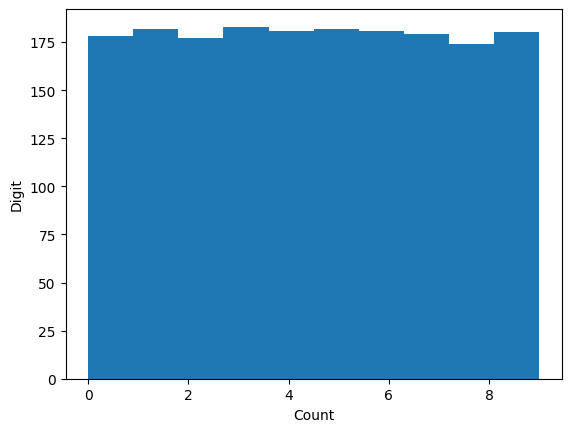

In [12]:
from matplotlib import pyplot as plt
plt.hist(y)
plt.xlabel('Count')
plt.ylabel('Digit');


Here we have roughly an equal number of observations per class.

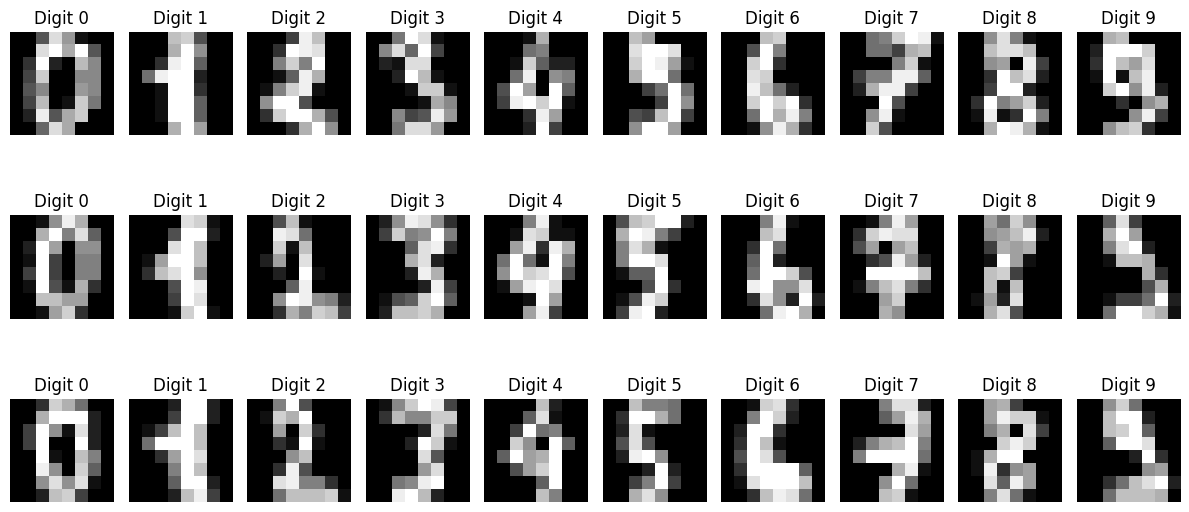

In [14]:
# Number of digits to plot
digits_to_plot = 10

# Number of versions of each digit to plot
n_versions = 3

# Create a figure with subplots
fig, axs = plt.subplots(n_versions, digits_to_plot, figsize=(12, 6))

# Loop through a small sample of digits and plot their raw images
for digit_idx in range(digits_to_plot):
    # Find up to n_versions occurrences of the current digit in the dataset
    indices = np.where(y == digit_idx)[0][:n_versions]

    for version_idx, index in enumerate(indices):
        # Reshape the 1D data into a 2D array (8x8 image)
        digit_image = x[index].reshape(8, 8)
        
        # Plot the raw image of the digit in the corresponding subplot
        axs[version_idx, digit_idx].imshow(digit_image, cmap='gray')
        axs[version_idx, digit_idx].set_title(f"Digit {digit_idx}")
        axs[version_idx, digit_idx].axis('off')

plt.tight_layout()
plt.show()

We're going to break down these images into how much information each pixel provides

In [18]:
var_per_feat = np.var(x, 0) # variabilty of data across each row
sum_var = var_per_feat.sum() # sum of variability across the rows
var_ratio = var_per_feat / sum_var

In [19]:
# check that the var ratio sums to one
print(var_ratio.sum())

1.0


In [21]:
sort_var_ratio_per_feat = np.sort(var_ratio)[::-1]

In [22]:
cumulative_var_ratio = np.cumsum(sort_var_ratio_per_feat) * 100

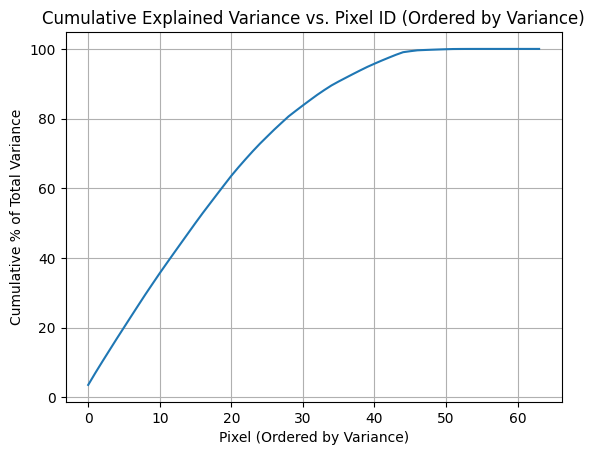

In [23]:
# Plot the cumulative variance ratios ordered from largest to smallest
plt.plot(cumulative_var_ratio)
plt.xlabel("Pixel (Ordered by Variance)")
plt.ylabel("Cumulative % of Total Variance")
plt.title("Cumulative Explained Variance vs. Pixel ID (Ordered by Variance)")
plt.grid(True)
plt.show()

Wtih each pixel/feature, representing just a small percentage of variability, it wil take many observations in order to train a good classifier. This is because it takes more observations for the model to learn how the features interact to predict a specific didigt.

In [24]:
from sklearn.model_selection import train_test_split

In [61]:
test_size = 0.1 # 0.98

In [62]:
# split the data into sections of variability, flat regions go together presumably
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, stratify=y)
# stratify will ensure that the train/test data has the same precentage of labels as the initial 'y' distribution

In [63]:
print(x_train.shape) # used to train
print(x_test.shape) # used to test

(1617, 64)
(180, 64)


**When the number of observations approaches or is less than the number of predictors, you greatly increase your risk of overfitting.**

Training Accuracy: 1.00
Test Accuracy: 0.99


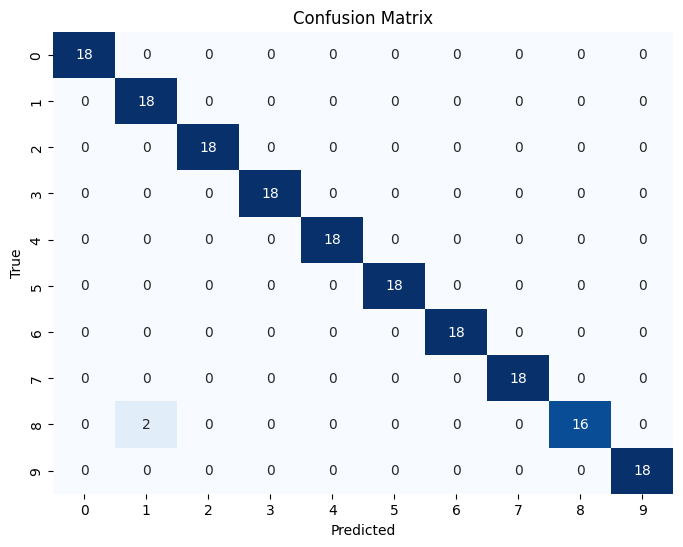

In [64]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def train_and_evaluate_mlp(X_train, X_test, y_train, y_test):
    # Create an MLP classifier
    # neural network (multilayer perceptron) that has MANY coefficients
    mlp = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=5000, random_state=42)

    # Fit the MLP model to the training data
    mlp.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_train_pred = mlp.predict(X_train)
    y_test_pred = mlp.predict(X_test)

    # Calculate the accuracy on the training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")
    
    # Calculate and plot the confusion matrix
    # 
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return train_accuracy, test_accuracy
    
train_and_evaluate_mlp(x_train, x_test, y_train, y_test);

### Interpreting the confusion matrix

Y -- true label for each image
X -- predicted value for the image

The diagonal has correct predictions. Other entries tell us which numbers the NN is confusing for other numbers.

### Training accuracy

A training accuracy of ~1.0 likely means you're overfitting the data


### PCA

Now we're going to introduce principal component analysis (PCA).

1. PCA, at it's core, is a data transformation technique
2. Allows us to more efficiently represent variability in our data
3. It does this by linearly combining variables into new variables called "principal component scores" -- NOTE: ppl often sloppily refer to them as principal components. 
4. The newly transformed variables are all "orthogonal" to one another, meaning there is no redundancy or correlation between variables.

In [29]:
from sklearn.decomposition import PCA

In [30]:
pca = PCA()
pca.fit(x) # in-place operation that stores the new basis dimensions (eigenvectors) that will be used to transform x

PCA()

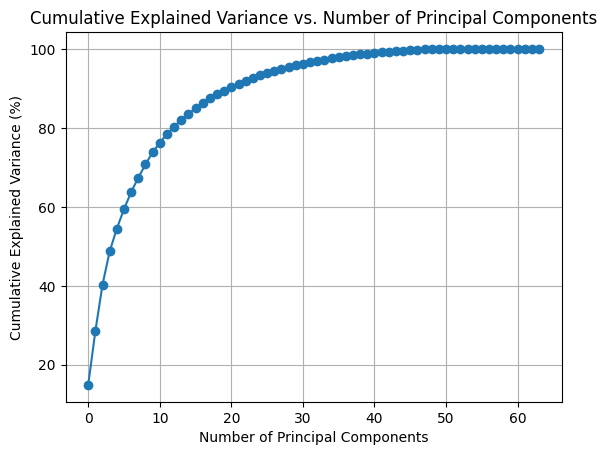

In [31]:
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum() * 100

# Plot the cumulative explained variance ratio
plt.plot(explained_variance_ratio_cumsum, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Cumulative Explained Variance vs. Number of Principal Components")
plt.grid(True)
plt.show()

After PCA, each column is able to represent more variability. The win for us is that we can now capture more of the variability with less of the data.

How many principal components (dimensions) should we keep?

 - Keep as many as are needed to reach a reasonable variance threshold (50-99% of the variability)
 - Look for inflection point in the CDF of the variance (elbow, knee)
 - There are data-driven method to assess overfitting effects with different numbers of components.
 
 In a high-dimensional context, tossingout a little information (components) can yield a model that will generalize much better rather than including all data and overfitting the model.

In [43]:
var_thresh = 50
n_components = np.argmax(explained_variance_ratio_cumsum >= var_thresh) +1 # number of components we need to capture at least 50% of the variance

In [44]:
n_components

5

In [45]:
x_pca = pca.transform(x)
x_pca.shape
x_pca = x_pca[:, :n_components]

In [46]:
x_pca.shape

(1797, 5)

Let's visualize some of the principal components. What were looking for here is grouping of the data by category.

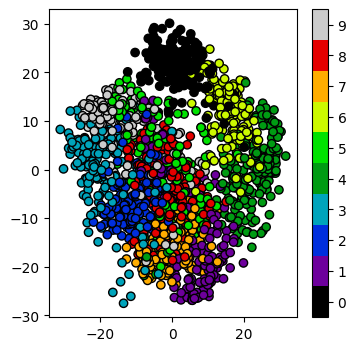

In [53]:
# plot the first two principal features of the dataset
fig = plt.figure(1, figsize=(4, 4))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap=plt.cm.nipy_spectral, 
        edgecolor='k',label=y)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.savefig("pca.svg")

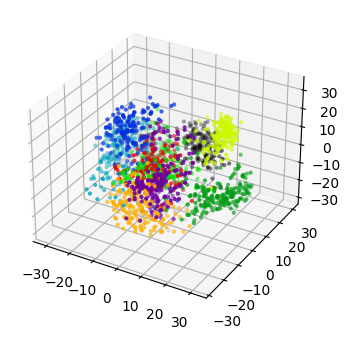

In [52]:
# same as above in 3D with 3 components
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y,
          cmap=plt.cm.nipy_spectral, s=9, lw=0);

In [54]:
# split the pca data into training and test data
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=test_size, random_state=42, stratify=y)

In [57]:
x_train_pca.shape

(35, 5)

Training Accuracy: 1.00
Test Accuracy: 0.72


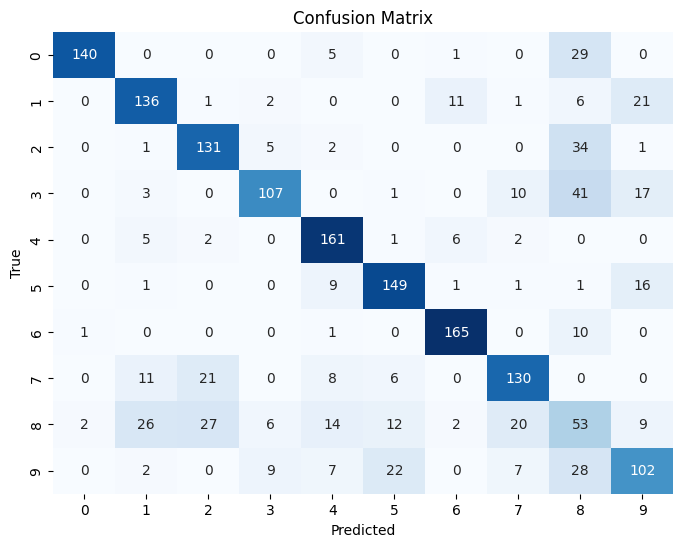

(1.0, 0.7230419977298524)

In [56]:
train_and_evaluate_mlp(x_train_pca, x_test_pca, y_train_pca, y_test_pca)

### Explore different variance thresholds (and their associated number of principal components)


[10, 20, 50, 60, 75, 90, 100]
var_thresh = 10%
n_components = 1
Training Accuracy: 0.40
Test Accuracy: 0.32


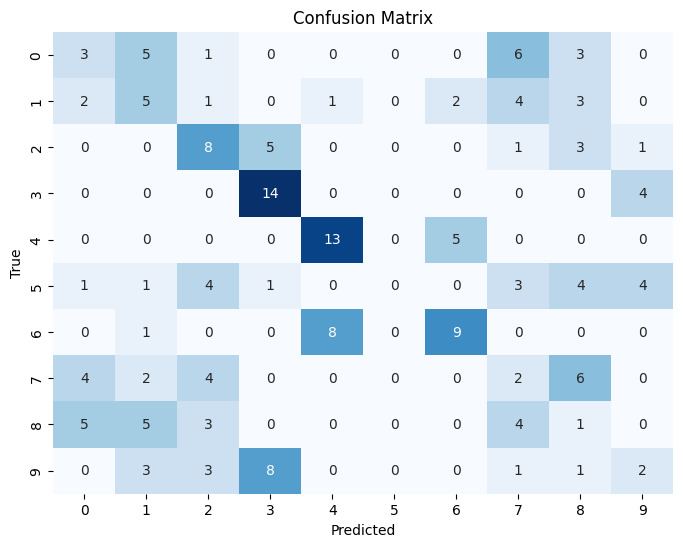

var_thresh = 20%
n_components = 2
Training Accuracy: 0.68
Test Accuracy: 0.64


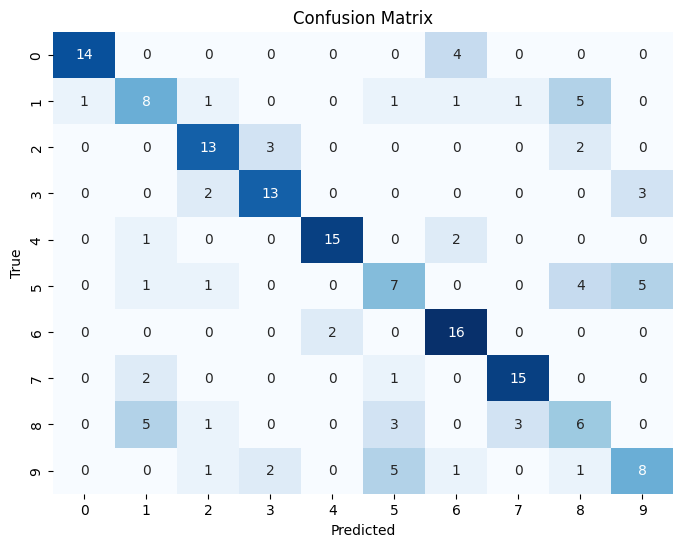

var_thresh = 50%
n_components = 5
Training Accuracy: 0.98
Test Accuracy: 0.94


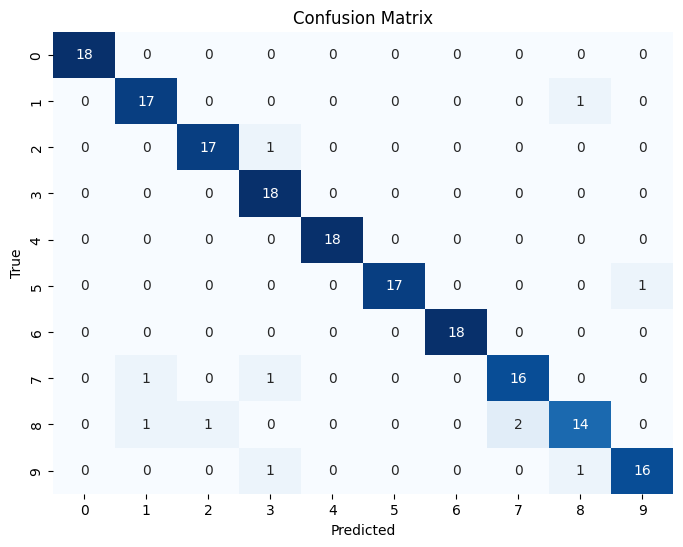

var_thresh = 60%
n_components = 7
Training Accuracy: 1.00
Test Accuracy: 0.94


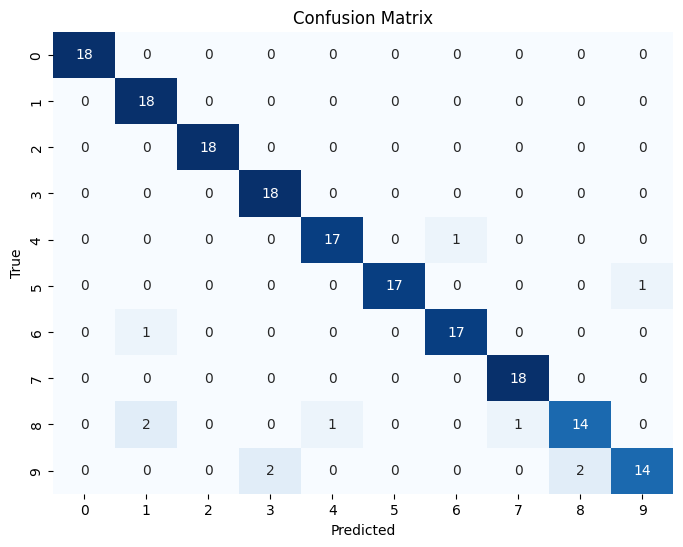

var_thresh = 75%
n_components = 11
Training Accuracy: 1.00
Test Accuracy: 0.96


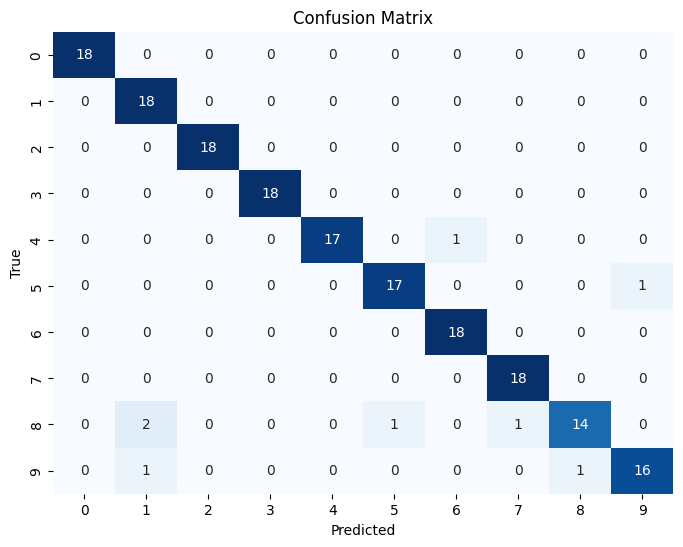

var_thresh = 90%
n_components = 21
Training Accuracy: 1.00
Test Accuracy: 0.97


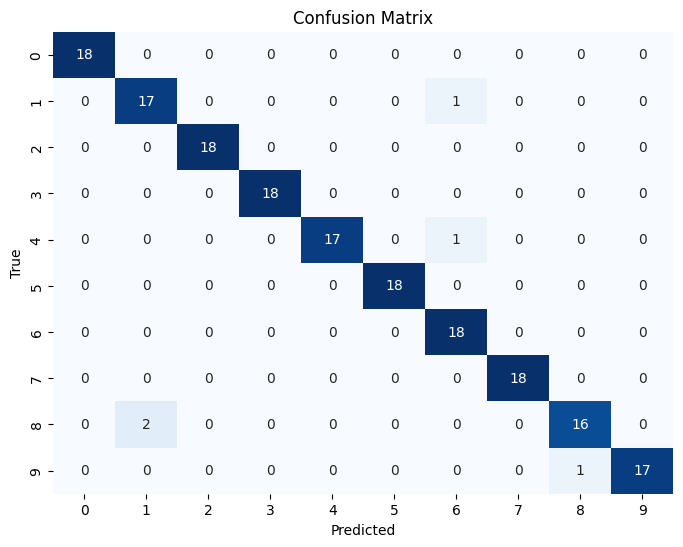

var_thresh = 100%
n_components = 61
Training Accuracy: 1.00
Test Accuracy: 0.98


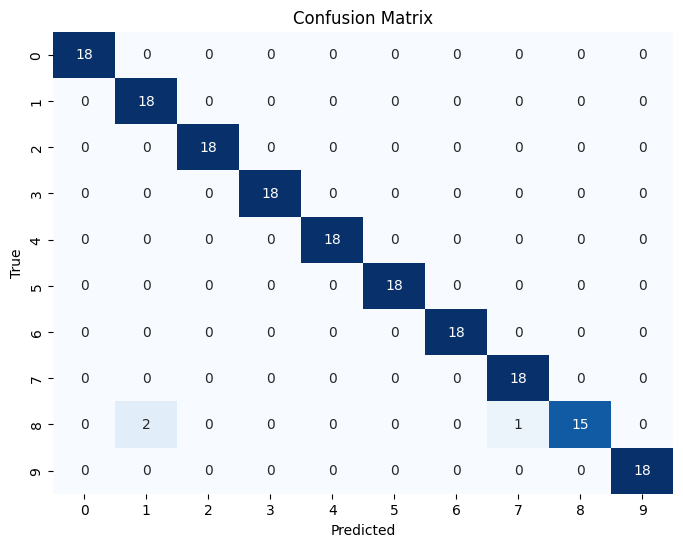

In [60]:
test_size = 0.1
var_thresh_list = [10, 20, 50, 60, 75, 90, 100]
print(var_thresh_list)
for var_thresh in var_thresh_list:
    print(f'var_thresh = {var_thresh}%')
    n_components = np.argmax(explained_variance_ratio_cumsum >= var_thresh) + 1
    print(f'n_components = {n_components}')
    X_pca = pca.transform(x) # transform X
    X_pca = X_pca[:, :n_components]
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=test_size, random_state=42, stratify=y)
    train_accuracy, test_accuracy = train_and_evaluate_mlp(X_train_pca, X_test_pca, y_train_pca, y_test_pca)